In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Categorical
import torchvision
from torchvision import transforms
from torchvision.transforms import functional as vision_F
from torchvision.models import resnet18


import numpy as np

from torch.utils.data import Dataset, DataLoader

from torchvision.models.resnet import BasicBlock, Bottleneck, conv1x1

from torch import Tensor
from typing import Union, Type, List, Optional, Callable

import matplotlib.pyplot as plt
from tqdm import tqdm

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [2]:
train_dataset = torchvision.datasets.CIFAR10('dataset', download=True)

class OneImageDataset(Dataset):
    def __init__(self, size, train_dataset):
        self.train_dataset = train_dataset
        self.size = size

    def __len__(self,):
        return self.size
    
    def __getitem__(self, i):
        img = transforms.ToTensor()(train_dataset[i][0])
        return img, img

def one_image_dataloader(num_steps, batch_size):

    return DataLoader(
        OneImageDataset(num_steps*batch_size, train_dataset),
        batch_size,
    )

Files already downloaded and verified


In [3]:
class DecoderRNN(nn.Module):
    def __init__(
            self,
            embed_size, 
            encoder_dim, 
            decoder_dim,
            num_transforms=4,
            num_discrete_magnitude=11,
            seq_length=10,
            drop_prob=0.3
        ):
        super().__init__()
        
        #save the model param
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim

        self.num_transforms = num_transforms
        self.num_discrete_magnitude = num_discrete_magnitude
        self.seq_length = seq_length


        len_action = num_transforms + num_discrete_magnitude + 1 # +1 for the first operation
        self.action_embedding = nn.Embedding(len_action, embed_size)
        self.branch_id_embedding = nn.Embedding(2, embed_size)

        # z + branch_id_embd + prev_action_embd
        self.rnn = nn.LSTMCell(encoder_dim + embed_size + embed_size , decoder_dim, bias=True)        
        
        self.fcn_transform = nn.Linear(decoder_dim,num_transforms)
        self.fcn_magnitude = nn.Linear(decoder_dim,num_discrete_magnitude)

    

    def init_hidden_state(self, batch_size):
        h = torch.zeros(batch_size, self.decoder_dim, device=device)
        c = torch.zeros(batch_size, self.decoder_dim, device=device)
        return h, c
    

    def lstm_forward(self, z, branch_id, prev_action, h_t, c_t, decoder):
        branch_id_embd   = self.branch_id_embedding(branch_id)
        prev_action_embd = self.action_embedding(prev_action)
        input = torch.concat(
            (z, branch_id_embd, prev_action_embd),
            dim=-1
        )
        h_t, c_t = self.rnn(input, (h_t, c_t))
        logits = decoder(h_t)
        return h_t, c_t, logits


    def forward(self, z1, z2, old_action_index=None):
        """
        returns:
            transform_actions_index: (batch_size, 2, seq_length)
            magnitude_actions_index: (batch_size, 2, seq_length)
            transform_log_p: (batch_size, 2, seq_length)
            magnitude_log_p: (batch_size, 2, seq_length)
        """
        if old_action_index is not None:
            (old_transform_actions_index, old_magnitude_actions_index) = old_action_index

        #get the seq length to iterate
        seq_length = self.seq_length
        batch_size = z1.size(0)
                
        # Initialize LSTM state
        h_t, c_t = self.init_hidden_state(batch_size)  # (batch_size, decoder_dim)
        
        transform_log_p =  torch.zeros(batch_size, 2, seq_length).to(device)
        transform_actions_index =  torch.zeros(batch_size, 2, seq_length, dtype=torch.long).to(device)

        magnitude_log_p =  torch.zeros(batch_size, 2, seq_length).to(device)
        magnitude_actions_index =  torch.zeros(batch_size, 2, seq_length, dtype=torch.long).to(device)

        branch_id = torch.full((batch_size,2), 0, dtype=torch.long, device=device)
        branch_id[:, 1] = 0
        
        features = [z1, z2]
        action_index = torch.LongTensor([self.num_transforms + self.num_discrete_magnitude]).to(device)
        action_index = action_index.repeat(batch_size)

        transform_entropy = 0
        magnitude_entropy = 0
        
        for branch in range(2):

            z = features[branch]

            for step in range(seq_length):
                
                h_t, c_t, logits = self.lstm_forward(
                    z=z,
                    branch_id=branch_id[:, branch],
                    prev_action=action_index,
                    h_t=h_t,
                    c_t=c_t,
                    decoder=self.fcn_transform
                )
                if old_action_index is None:
                    action_index = Categorical(logits=logits).sample()
                else:
                    action_index = old_transform_actions_index[:, branch, step]
                log_p = F.log_softmax(logits, dim=-1).gather(-1,action_index.unsqueeze(-1))
                transform_log_p[:, branch, step] = log_p.squeeze(-1)
                transform_actions_index[:, branch, step] = action_index


                h_t, c_t, logits = self.lstm_forward(
                    z=z,
                    branch_id=branch_id[:, branch],
                    prev_action=action_index,
                    h_t=h_t,
                    c_t=c_t,
                    decoder=self.fcn_magnitude
                )
                if old_action_index is None:
                    action_index = Categorical(logits=logits).sample()
                else:
                    action_index = old_magnitude_actions_index[:, branch, step]
                log_p = F.log_softmax(logits, dim=-1).gather(-1,action_index.unsqueeze(-1))
                magnitude_log_p[:, branch, step] = log_p.squeeze(-1)
                magnitude_actions_index[:, branch, step] = action_index

    
        return (
                (transform_actions_index, transform_log_p),
                (magnitude_actions_index, magnitude_log_p)
            )

In [4]:
class SimCLR(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        self.enc = resnet18(weights=None)  # load model from torchvision.models without pretrained weights.
        self.feature_dim = self.enc.fc.in_features

        # Customize for CIFAR10. Replace conv 7x7 with conv 3x3, and remove first max pooling.
        # See Section B.9 of SimCLR paper.
        self.enc.conv1 = nn.Conv2d(3, 64, 3, 1, 1, bias=False)
        self.enc.maxpool = nn.Identity()
        self.enc.fc = nn.Identity()  # remove final fully connected layer.

        # Add MLP projection.
        self.projection_dim = projection_dim
        self.projector = nn.Sequential(nn.Linear(self.feature_dim, 2048),
                                       nn.ReLU(),
                                       nn.Linear(2048, projection_dim))

    def forward(self, x):
        feature = self.enc(x)
        projection = self.projector(feature)
        return feature, projection
    
    
def build_resnet18():
    return SimCLR()

In [5]:
encoder = build_resnet18()
encoder.load_state_dict(torch.load('params/resnet18_contrastive_only_colorjitter.pt'))
encoder = encoder.to(device)

decoder = DecoderRNN(
    embed_size=8,
    encoder_dim=128,
    decoder_dim=512,
    num_transforms=4,
    num_discrete_magnitude=10,
    seq_length=5
).to(device)

img1, img2 = next(iter(one_image_dataloader(10, 16)))
img1 = img1.to(device)
_, z = encoder(img1)

# Inference:
transform_preds, magnitude_preds = decoder(z, z)
transform_actions_index, transform_log_p = transform_preds
magnitude_actions_index, magnitude_log_p = magnitude_preds

# Get the proba:
new_transform_preds, new_magnitude_preds = decoder(z, z, old_action_index=(transform_actions_index, magnitude_actions_index))
new_transform_actions_index, new_transform_log_p = new_transform_preds
new_magnitude_actions_index, new_magnitude_log_p = new_magnitude_preds

(transform_log_p == new_transform_log_p).all(), (magnitude_log_p == new_magnitude_log_p).all()

(tensor(True, device='cuda:0'), tensor(True, device='cuda:0'))

In [6]:
TRANSFORMS_DICT = [
    ('brightness', vision_F.adjust_brightness, (0.6, 1.4)),
    ('contrast', vision_F.adjust_contrast, (0.6, 1.4)),
    ('saturation', vision_F.adjust_saturation, (0.6, 1.4)),
    ('hue', vision_F.adjust_hue, (-0.1, 0.1)),
]

def get_transforms_list(actions_transform, actions_magnitude):

    all_transform_lists = []
    for branch in range(actions_transform.size(1)):
        branch_transform_lists = []
        
        for i in range(actions_transform.size(0)):
            transform_list = []

            for s in range(actions_transform.size(2)):
                transform_id = actions_transform[i, branch, s].item()
                magnitude_id = actions_magnitude[i, branch, s].item()
                func_name, func, (lower, upper) = TRANSFORMS_DICT[transform_id]
                step = (upper - lower) / 10
                magnitude = np.arange(start=lower, stop=upper+step, step=step)[magnitude_id]
                transform_list.append((func_name, func, round(magnitude, 5)))
            branch_transform_lists.append(transform_list)
    
        all_transform_lists.append(branch_transform_lists)
        
    return all_transform_lists[0], all_transform_lists[1]


def apply_transformations(img1, transform_list):

    num_samples = img1.size(0)
    stored_imgs = torch.zeros((num_samples, 3, 32, 32))

    for i in range(img1.size(0)):
        img = img1[i]
        for (transform_name, transform_func, magnitude) in transform_list[i]:
            img = transform_func(img, magnitude)
        stored_imgs[i] = img

    return stored_imgs


In [7]:
def multi_dimensional_multinomial(x):
    *leading_axes, last_ax = x.shape
    x = x.reshape((-1, last_ax))
    actions = torch.multinomial(x, 1)
    actions = actions.reshape(leading_axes)
    return actions


def collect_trajectories(len_trajectory, encoder, decoder, batch_size):

    assert len_trajectory % batch_size == 0

    data_loader = one_image_dataloader(
        num_steps=len_trajectory // batch_size,
        batch_size=batch_size
    )

    encoder_dim = encoder.projector[2].out_features


    stored_z1 = torch.zeros((len_trajectory, encoder_dim))
    stored_z2 = torch.zeros((len_trajectory, encoder_dim))
    stored_transform_log_p = torch.zeros((len_trajectory, 2, decoder.seq_length))
    stored_magnitude_log_p = torch.zeros((len_trajectory, 2, decoder.seq_length))
    stored_transform_actions_index  = torch.zeros((len_trajectory, 2, decoder.seq_length), dtype=torch.long)
    stored_magnitude_actions_index  = torch.zeros((len_trajectory, 2, decoder.seq_length), dtype=torch.long)
    stored_rewards = torch.zeros((len_trajectory,))

    data_loader_iterator = iter(data_loader)
    for i in range(len_trajectory // batch_size):
    # for i in tqdm(range(len_trajectory // batch_size)):

        begin, end = i*batch_size, (i+1)*batch_size

        img1, img2 = next(data_loader_iterator)

        img1 = img1.to(device)
        img2 = img2.to(device)

        with torch.no_grad():
            _, z1 = encoder(img1)
            _, z2 = encoder(img2)

        with torch.no_grad():
            transform_preds, magnitude_preds = decoder(z1, z2)
            transform_actions_index, transform_log_p = transform_preds
            magnitude_actions_index, magnitude_log_p = magnitude_preds


        transforms_list_1, transforms_list_2 = get_transforms_list(transform_actions_index, magnitude_actions_index)
        new_img1 = apply_transformations(img1, transforms_list_1)
        new_img2 = apply_transformations(img2, transforms_list_2)

        new_img1 = new_img1.to(device)
        new_img2 = new_img2.to(device)
        with torch.no_grad():
            _, new_z1 = encoder(new_img1)
            _, new_z2 = encoder(new_img2)
        new_img1 = new_img1.to('cpu')
        new_img2 = new_img2.to('cpu')



        stored_z1[begin:end] = z1.detach().cpu()
        stored_z2[begin:end] = z1.detach().cpu()
        stored_transform_log_p[begin:end] = transform_log_p.detach().cpu()
        stored_magnitude_log_p[begin:end] = magnitude_log_p.detach().cpu()
        stored_transform_actions_index[begin:end]  = transform_actions_index.detach().cpu()
        stored_magnitude_actions_index[begin:end]  = magnitude_actions_index.detach().cpu()
        # stored_rewards[begin:end] = (new_img1 - new_img2).reshape(batch_size, -1).mean(axis=1)
        stored_rewards[begin:end] = - (F.normalize(new_z1) * F.normalize(new_z2)).sum(axis=-1)


    return (
            (stored_z1, stored_z2), 
            (stored_transform_log_p, stored_magnitude_log_p),
            (stored_transform_actions_index, stored_magnitude_actions_index),
            stored_rewards
        ), (img1, img2, new_img1, new_img2)

# trajectory = collect_trajectories(1024, encoder, decoder, 1024)

In [8]:
def shuffle_trajectory(trajectory):

    (
        (stored_z1, stored_z2), 
        (stored_transform_log_p, stored_magnitude_log_p),
        (stored_transform_actions_index, stored_magnitude_actions_index),
        stored_rewards
    ) = trajectory

    permutation = torch.randperm(stored_z1.size()[0])

    permuted_stored_z1 = stored_z1[permutation]
    permuted_stored_z2 = stored_z2[permutation]
    permuted_stored_transform_log_p = stored_transform_log_p[permutation]
    permuted_stored_magnitude_log_p = stored_magnitude_log_p[permutation]
    permuted_stored_transform_actions_index  = stored_transform_actions_index[permutation]
    permuted_stored_magnitude_actions_index  = stored_magnitude_actions_index[permutation]
    permuted_stored_rewards = stored_rewards[permutation]

    permuted_trajectory = (
        (permuted_stored_z1, permuted_stored_z2),
        (permuted_stored_transform_log_p, permuted_stored_magnitude_log_p),
        (permuted_stored_transform_actions_index, permuted_stored_magnitude_actions_index),
        permuted_stored_rewards
    )

    return permuted_trajectory

In [9]:
def calculate_entropy(probabilities):
    epsilon = 1e-12
    log_probabilities = torch.log(probabilities + epsilon)
    entropy = -torch.sum(probabilities * log_probabilities, dim=-1)
    return entropy

def ppo_update(trajectory, decoder, optimizer, value_criterion, ppo_batch_size=256, ppo_epochs=4):


    for _ in range(ppo_epochs):
    
        shuffled_trajectory = shuffle_trajectory(trajectory)

        (
            (stored_z1, stored_z2), 
            (stored_transform_log_p, stored_magnitude_log_p),
            (stored_transform_actions_index, stored_magnitude_actions_index),
            stored_rewards
        ) = shuffled_trajectory

        len_trajectory = stored_z1.shape[0]


        assert len_trajectory % ppo_batch_size == 0

        acc_loss = 0
        acc_loss_counter = 0
        for i in range(len_trajectory // ppo_batch_size):

            begin, end = i*ppo_batch_size, (i+1)*ppo_batch_size

            z1 = stored_z1[begin:end].to(device).detach()
            z2 = stored_z2[begin:end].to(device).detach()
            old_transform_log_p = stored_transform_log_p[begin:end].to(device).detach()
            old_magnitude_log_p = stored_magnitude_log_p[begin:end].to(device).detach()
            transform_actions_index = stored_transform_actions_index[begin:end].to(device).detach()
            magnitude_actions_index = stored_magnitude_actions_index[begin:end].to(device).detach()
            reward = stored_rewards[begin:end].to(device).detach()

            new_transform_preds, new_magnitude_preds = decoder(z1, z2, old_action_index=(transform_actions_index, magnitude_actions_index))
            new_transform_actions_index, new_transform_log_p = new_transform_preds
            new_magnitude_actions_index, new_magnitude_log_p = new_magnitude_preds
            
            assert (transform_actions_index == new_transform_actions_index).all()
            assert (magnitude_actions_index == new_magnitude_actions_index).all()
            

            # entropy_loss = calculate_entropy(new_transform_p).mean() + calculate_entropy(new_magnitude_p).mean()
            # entropy_loss = -1. *  entropy_loss
            # print('entropy:', entropy.item())


            old_log_p = torch.concatenate((old_transform_log_p, old_magnitude_log_p), dim=-1)
            new_log_p = torch.concatenate((new_transform_log_p, new_magnitude_log_p), dim=-1)

            old_log_p = old_log_p.reshape(ppo_batch_size, -1)
            new_log_p = new_log_p.reshape(ppo_batch_size, -1)

        
            advantage = reward
            advantage = (advantage - advantage.mean()) / (advantage.std() + 1e-8)
            advantage = advantage.unsqueeze(-1)
            ratio = torch.exp(new_log_p - old_log_p.detach())

            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1-0.2, 1+0.2) * advantage
            actor_loss = - torch.min(surr1, surr2).mean()

            loss = actor_loss

            # print('old_log_p', old_log_p.shape)
            # print('advantage', advantage.shape)
            # print('ratio', ratio.shape)
            # print('torch.min(surr1, surr2)', torch.min(surr1, surr2).shape)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            acc_loss += loss.item()
            acc_loss_counter += 1

    return acc_loss / acc_loss_counter
    

---

In [10]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

In [13]:
def init():

    encoder = build_resnet18()
    encoder.load_state_dict(torch.load('params/resnet18_contrastive_only_colorjitter.pt'))
    encoder = encoder.to(device)

    decoder = DecoderRNN(
        embed_size=1024,
        encoder_dim=128,
        decoder_dim=512,
        num_transforms=4,
        num_discrete_magnitude=10,
        seq_length=4
    ).to(device)

    optimizer = torch.optim.Adam(
        decoder.parameters(),
        lr=0.001
    )

    value_criterion = nn.MSELoss()
    list(decoder.parameters())[-1]

    return encoder, decoder, optimizer, value_criterion

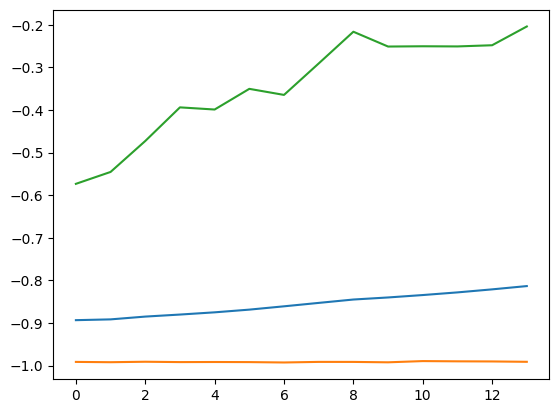

Reward: -0.782374        Loss: -0.006660:   5%|▍         | 14/300 [00:12<04:05,  1.16it/s]


KeyboardInterrupt: 

In [14]:

encoder, decoder, optimizer, value_criterion = init()

rewards = []
min_rewards = []
max_rewards = []


tqdm_range = tqdm(range(300))
for step in tqdm_range:

    trajectory, (img1, img2, new_img1, new_img2) = collect_trajectories(
        len_trajectory=256,
        encoder=encoder,
        decoder=decoder,
        batch_size=256
    )

    loss = ppo_update(
        trajectory,
        decoder,
        optimizer,
        ppo_epochs=4,
        ppo_batch_size=64,
        value_criterion=value_criterion
    )

    mean_reward = float(trajectory[-1].mean())
    min_reward = float(trajectory[-1].min())
    max_reward = float(trajectory[-1].max())



    tqdm_range.set_description(f'Reward: {mean_reward:.6f}        Loss: {loss:.6f}')

    rewards.append(mean_reward)
    min_rewards.append(min_reward)
    max_rewards.append(max_reward)
    
    clear_output(True)
    plt.plot(smooth_curve(rewards))
    plt.plot(smooth_curve(min_rewards))
    plt.plot(smooth_curve(max_rewards))
    plt.show()


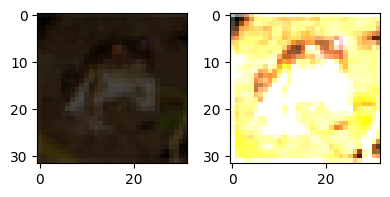

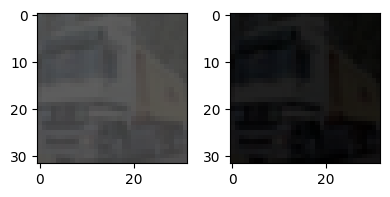

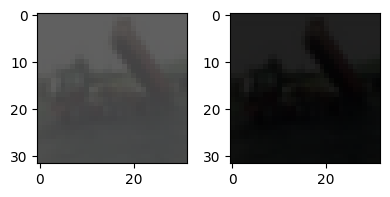

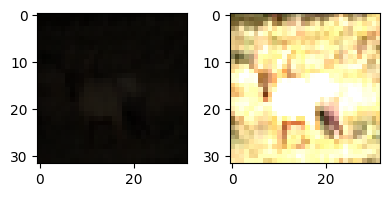

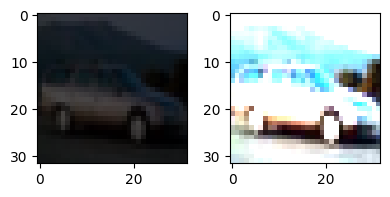

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_two_subplots(img1, img2):
    fig, axs = plt.subplots(1, 2, figsize=(4, 4))  # 1 row, 2 columns
    axs[0].imshow(img1)
    axs[1].imshow(img2)
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_two_subplots(new_img1[i].permute(1,2,0), new_img2[i].permute(1,2,0))

In [49]:
print()